In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
import os

delta = 3
min_area = 100
max_area = 600

In [2]:
import os
import re
import cv2

## Read Images from 10 folders named (00001,00002,...,00010)
## Each folder contains images in .bmp format and a .txt file with the name groundtruth.txt
## groundtruth.txt contains the coordinates of the bounding box of the object in the image
## The images are of size 360x240

# Path to the folder containing the 10 folders
def read_images(path="./datasets/OTCBVS_Pedestrian"):
    # path = "./datasets/OTCBVS_Pedestrian"

    ## Extract Bounding Boxes from groundtruth.txt files
    # Loop over the 10 folders
    boxes = {}
    for i in range(1,11):
        # Path to the folder
        if i < 10:
            path_folder = path + "/0000" + str(i)
        else:
            path_folder = path + "/000" + str(i)
        # Path to the groundtruth.txt file
        path_txt = path_folder + "/groundTruth.txt"
        # Open the groundtruth.txt file
        txt = open(path_txt, "r")
        # Loop over the lines of the file
        for _ in range(4):
            next(txt)           # Skip the first 4 lines
        
        folder_boxes = []
        # Loop over the lines of the file
        for line in txt:
            box = []
            matches = re.findall(r'\((\d+) (\d+) (\d+) (\d+)\)', line)
            # Loop over the matches

            if matches:
                for match in matches:
                    # Extract the coordinates of the bounding box
                    x1, y1 , x2 , y2 = map(int, match)
                    # print("x1: ", x1, "y1: ", y1, "x2: ", x2, "y2: ", y2)
                    # Append the coordinates to the list
                    box.append([x1, y1, x2, y2])
            
            folder_boxes.append(box)
        
        if i < 10:
            boxes["0000" + str(i)] = folder_boxes
        else:
            boxes["000" + str(i)] = folder_boxes

        txt.close()

    # print(len(boxes["00001"]))

    ## Extract Images from .bmp files
    # Loop over the 10 folders
    images = {}
    for i in range(1,11):
        # Path to the folder
        if i < 10:
            path_folder = path + "/0000" + str(i)
        else:
            path_folder = path + "/000" + str(i)
        # Path to the .bmp files
        path_bmp = path_folder
        # List of the .bmp files
        bmp_files = os.listdir(path_bmp)
        # Sort the list of the .bmp files
        bmp_files.sort()
        # Loop over the .bmp files
        folder_images = []

        for bmp_file in bmp_files:
            if bmp_file.endswith(".bmp"):
                
                # Path to the .bmp file
                path_bmp_file = path_bmp + "/" + bmp_file
                # # Open the .bmp file
                # bmp = open(path_bmp_file, "rb")
                # # Read the .bmp file
                # bmp_data = bmp.read()
                # # Append the .bmp file to the list
                # folder_images.append(bmp_data)
                # bmp.close()
                image = cv2.imread(path_bmp_file)

                # Apply Image Enhancement
                # image = image_enhance(image)

                # Append the .bmp file to the list
                folder_images.append(image)


            
        if i < 10:
            images["0000" + str(i)] = folder_images
        else:
            images["000" + str(i)] = folder_images
            
    
    return images, boxes


images, boxes = read_images()

# print(len(boxes["00002"][27]))


In [3]:
import cv2

def image_enhance(x):
    # Convert to grayscale
    x_gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

    # Image sharpening
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]], dtype=np.float32)
    y1 = cv2.filter2D(x_gray, -1, kernel)

    # Morphological opening
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    background = cv2.morphologyEx(x_gray, cv2.MORPH_OPEN, se)
    y2 = cv2.subtract(x_gray, background)
    y2 = cv2.normalize(y2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Histogram equalization
    y3 = cv2.equalizeHist(x_gray)

    # Deconvolution (you can adjust PSF and regularization parameters as needed)
    PSF = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
    y4 = cv2.filter2D(x_gray, -1, PSF)

    # Weighted average of enhanced images
    y = cv2.addWeighted(y1, 0.25, y2, 0.25, 0)
    y = cv2.addWeighted(y, 0.25, y3, 0.25, 0)
    y = cv2.addWeighted(y, 0.25, y4, 0.25, 0)

    return y

# get MSER regions
def getMSERregions(img):
    # create MSER object
    mser = cv2.MSER_create(delta = delta, min_area = min_area, max_area = max_area)
    # detect MSER regions
    regions, mser_bboxes = mser.detectRegions(img)
    # get bounding boxes from regions
    bboxes = []
    for region in regions:
        x, y, w, h = cv2.boundingRect(region)
        bboxes.append([x, y, x+w, y+h])
    return bboxes , mser_bboxes

# get MSER regions from all images
def getMSERregionsAll(images):
    # create dictionary to store MSER regions
    regions = {}
    # loop over all images
    for key in images.keys():
        # create list to store MSER regions
        regions[key] = []
        # loop over all images in folder
        for img in images[key]:
            # convert image to grayscale
            img = image_enhance(img)
            # get MSER regions
            bboxes , mser_bboxes = getMSERregions(img)
            # append MSER regions to list
            regions[key].append(bboxes)
    return regions


Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5


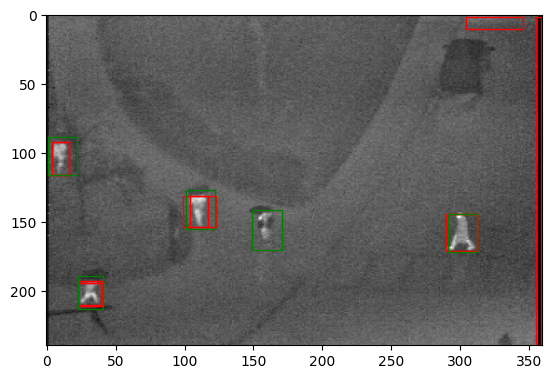

Image 1 : img_00002.bmp
img_00002.bmp
No. of boxes in image 1 : 5
No. of boxes in image 1 : 5
No. of boxes in image 1 : 5
No. of boxes in image 1 : 5
No. of boxes in image 1 : 5


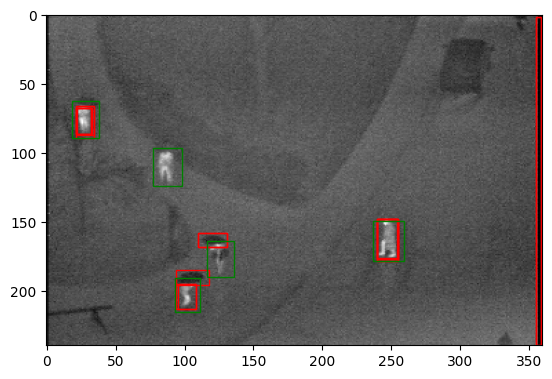

Image 2 : img_00003.bmp
img_00003.bmp
No. of boxes in image 2 : 1


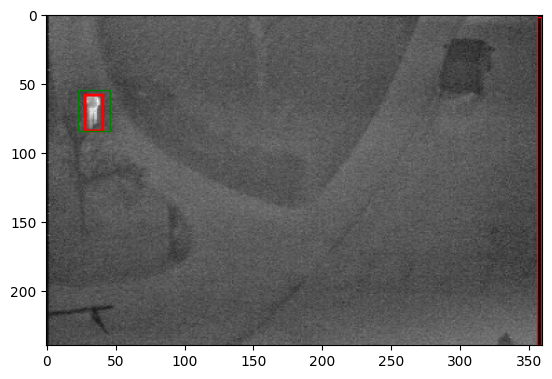

Image 3 : img_00004.bmp
img_00004.bmp
No. of boxes in image 3 : 1


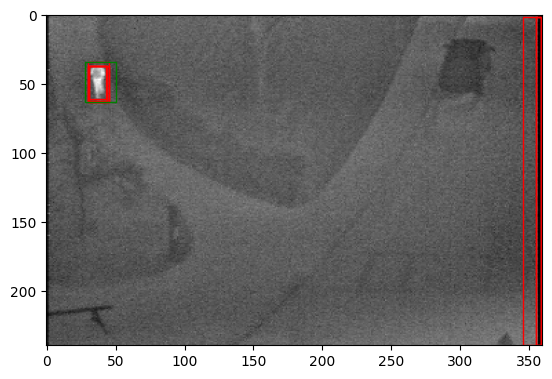

Image 4 : img_00005.bmp
img_00005.bmp
No. of boxes in image 4 : 2
No. of boxes in image 4 : 2


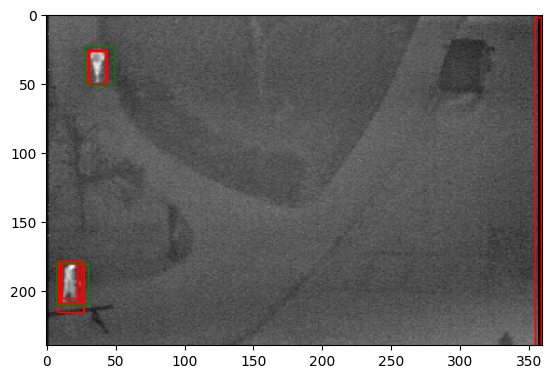

Image 5 : img_00006.bmp
img_00006.bmp
No. of boxes in image 5 : 2
No. of boxes in image 5 : 2


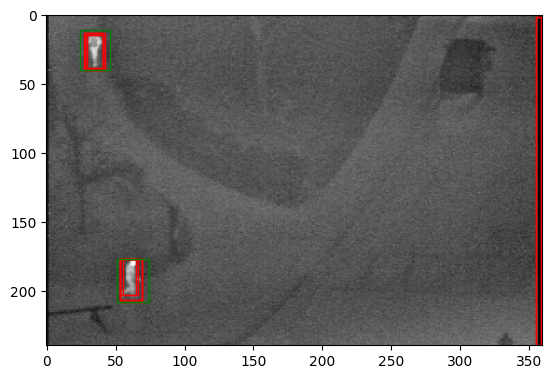

Image 6 : img_00007.bmp
img_00007.bmp
No. of boxes in image 6 : 2
No. of boxes in image 6 : 2


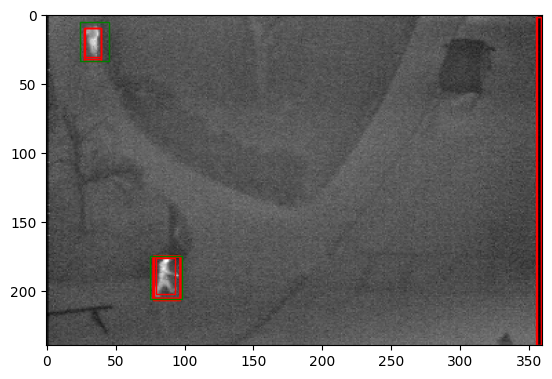

Image 7 : img_00008.bmp
img_00008.bmp
No. of boxes in image 7 : 2
No. of boxes in image 7 : 2


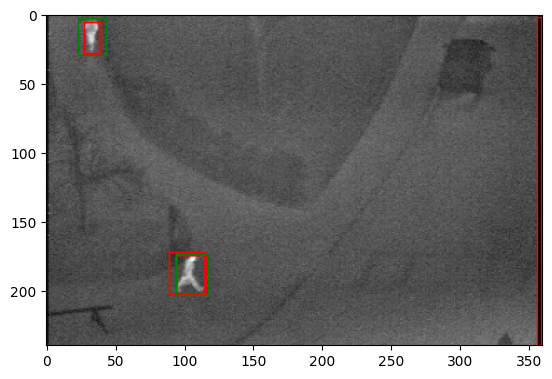

Image 8 : img_00009.bmp
img_00009.bmp
No. of boxes in image 8 : 1


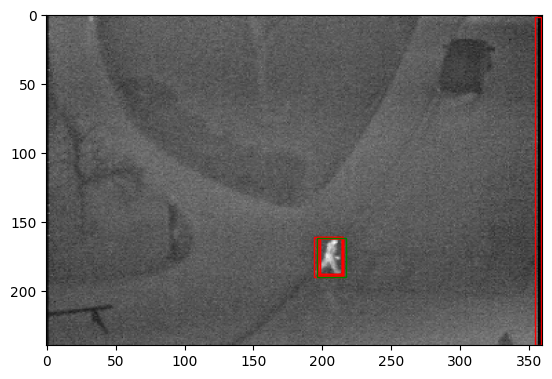

Image 9 : img_00010.bmp
img_00010.bmp
No. of boxes in image 9 : 1


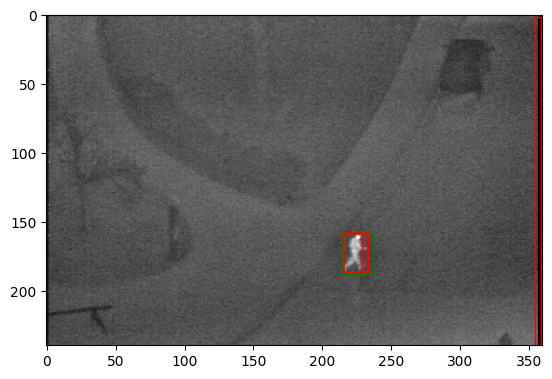

Image 10 : img_00011.bmp
img_00011.bmp
No. of boxes in image 10 : 1


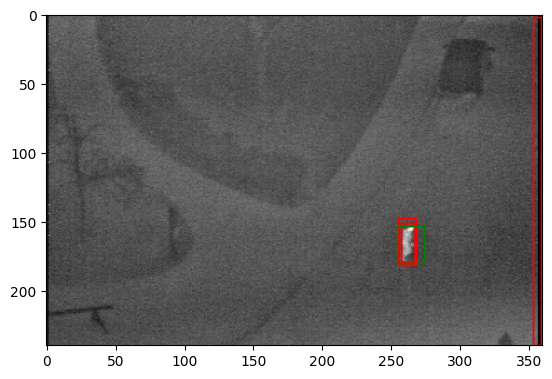

Image 11 : img_00012.bmp
img_00012.bmp
No. of boxes in image 11 : 1


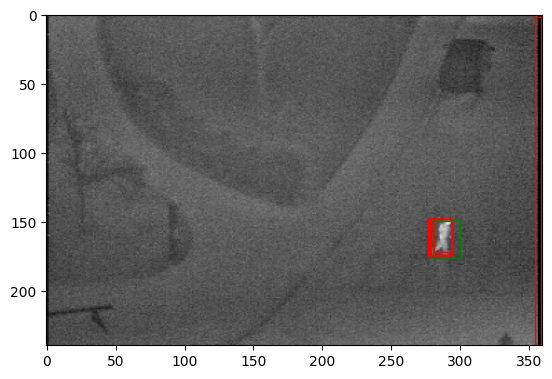

Image 12 : img_00013.bmp
img_00013.bmp
No. of boxes in image 12 : 1


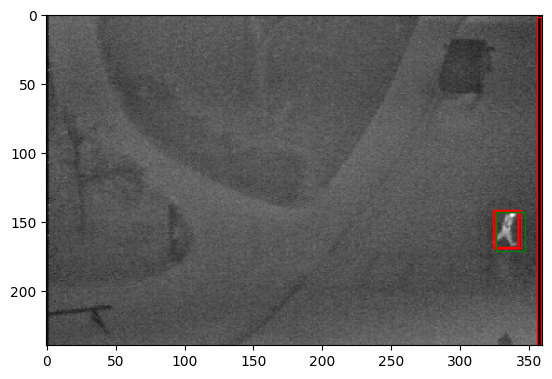

Image 13 : img_00014.bmp
img_00014.bmp
No. of boxes in image 13 : 2
No. of boxes in image 13 : 2


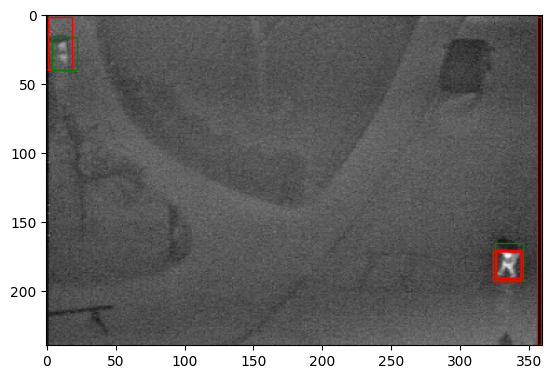

Image 14 : img_00015.bmp
img_00015.bmp
No. of boxes in image 14 : 2
No. of boxes in image 14 : 2


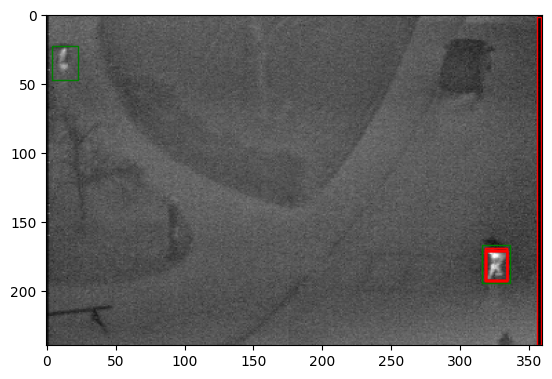

Image 15 : img_00016.bmp
img_00016.bmp
No. of boxes in image 15 : 2
No. of boxes in image 15 : 2


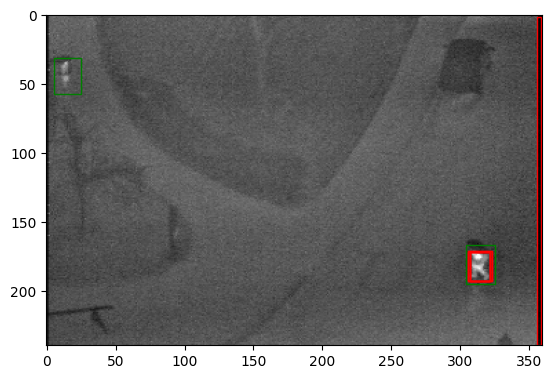

Image 16 : img_00017.bmp
img_00017.bmp
No. of boxes in image 16 : 2
No. of boxes in image 16 : 2


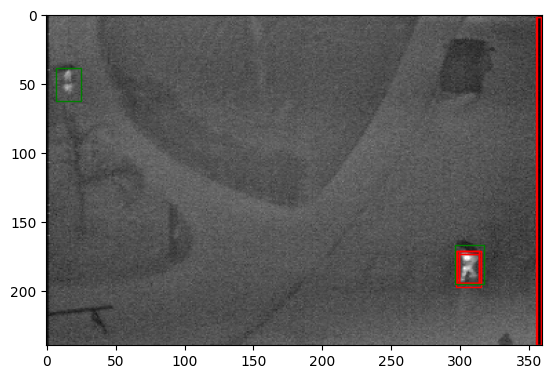

Image 17 : img_00018.bmp
img_00018.bmp
No. of boxes in image 17 : 2
No. of boxes in image 17 : 2


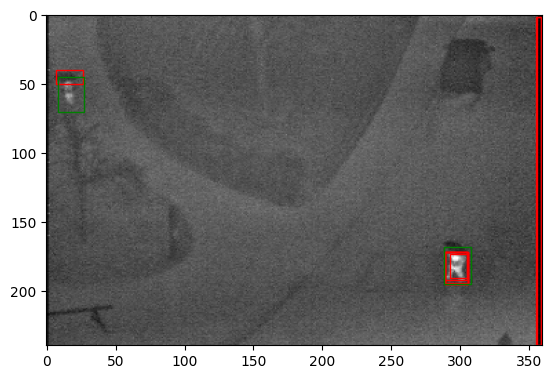

Image 18 : img_00019.bmp
img_00019.bmp
No. of boxes in image 18 : 2
No. of boxes in image 18 : 2


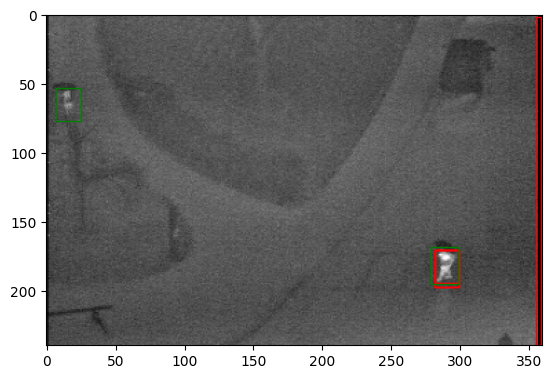

Image 19 : img_00020.bmp
img_00020.bmp
No. of boxes in image 19 : 3
No. of boxes in image 19 : 3
No. of boxes in image 19 : 3


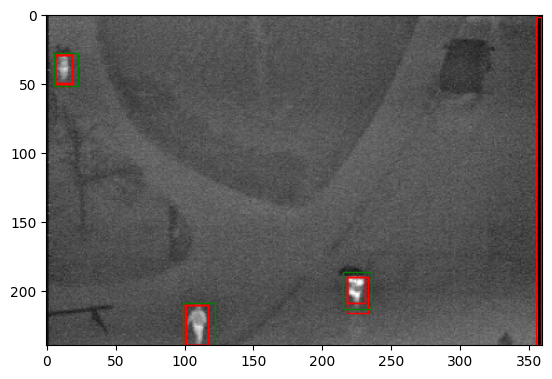

Image 20 : img_00021.bmp
img_00021.bmp
No. of boxes in image 20 : 3
No. of boxes in image 20 : 3
No. of boxes in image 20 : 3


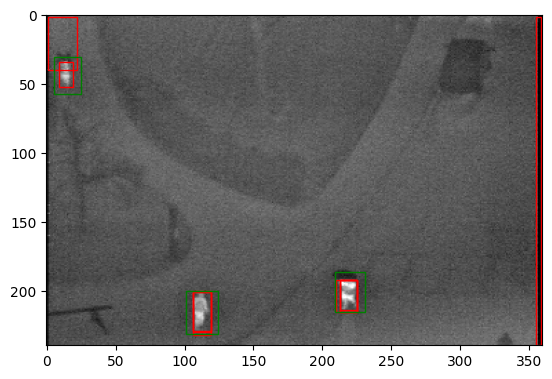

Image 21 : img_00022.bmp
img_00022.bmp
No. of boxes in image 21 : 3
No. of boxes in image 21 : 3
No. of boxes in image 21 : 3


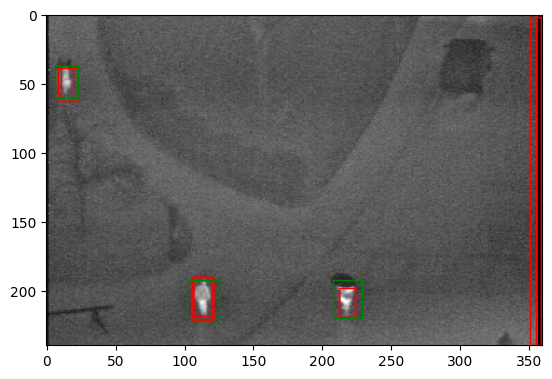

Image 22 : img_00023.bmp
img_00023.bmp
No. of boxes in image 22 : 3
No. of boxes in image 22 : 3
No. of boxes in image 22 : 3


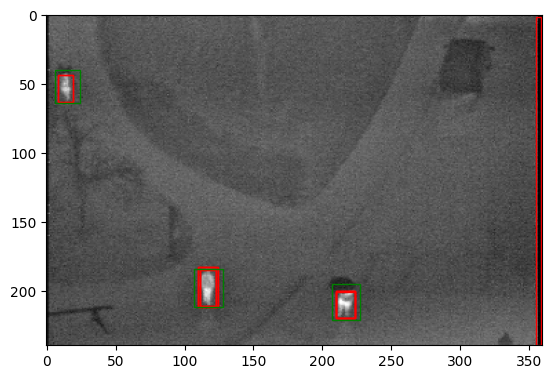

Image 23 : img_00024.bmp
img_00024.bmp
No. of boxes in image 23 : 3
No. of boxes in image 23 : 3
No. of boxes in image 23 : 3


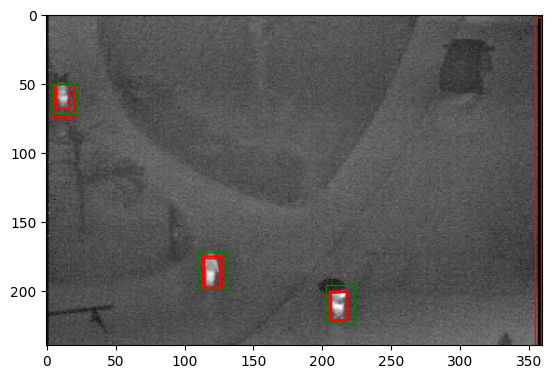

Image 24 : img_00025.bmp
img_00025.bmp
No. of boxes in image 24 : 4
No. of boxes in image 24 : 4
No. of boxes in image 24 : 4
No. of boxes in image 24 : 4


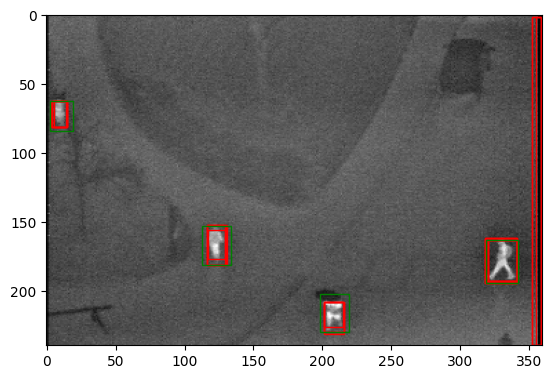

Image 25 : img_00026.bmp
img_00026.bmp
No. of boxes in image 25 : 3
No. of boxes in image 25 : 3
No. of boxes in image 25 : 3


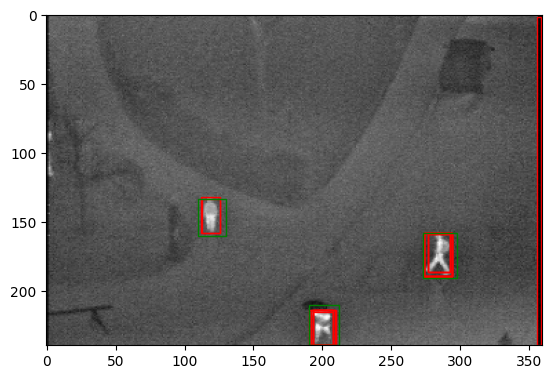

Image 26 : img_00027.bmp
img_00027.bmp
No. of boxes in image 26 : 4
No. of boxes in image 26 : 4
No. of boxes in image 26 : 4
No. of boxes in image 26 : 4


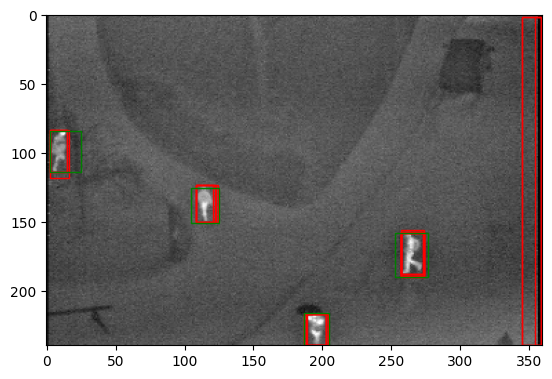

Image 27 : img_00028.bmp
img_00028.bmp
No. of boxes in image 27 : 7
No. of boxes in image 27 : 7
No. of boxes in image 27 : 7
No. of boxes in image 27 : 7
No. of boxes in image 27 : 7
No. of boxes in image 27 : 7
No. of boxes in image 27 : 7


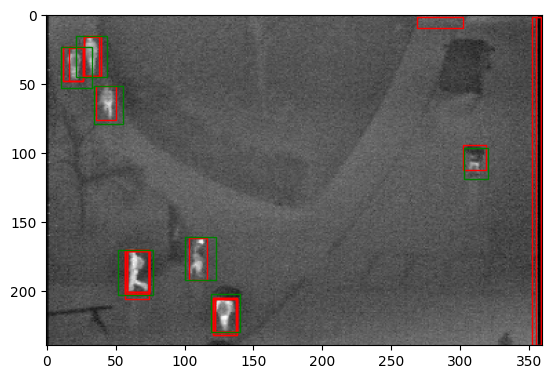

Image 28 : img_00029.bmp
img_00029.bmp
No. of boxes in image 28 : 7
No. of boxes in image 28 : 7
No. of boxes in image 28 : 7
No. of boxes in image 28 : 7
No. of boxes in image 28 : 7
No. of boxes in image 28 : 7
No. of boxes in image 28 : 7


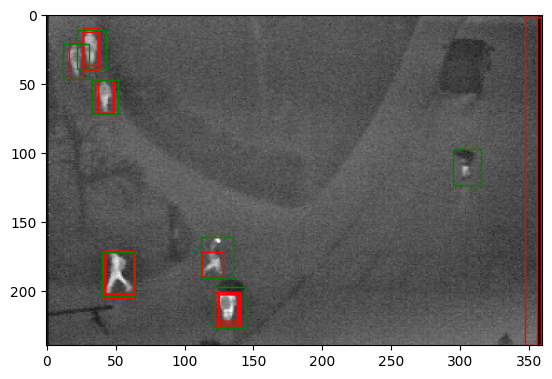

Image 29 : img_00030.bmp
img_00030.bmp
No. of boxes in image 29 : 7
No. of boxes in image 29 : 7
No. of boxes in image 29 : 7
No. of boxes in image 29 : 7
No. of boxes in image 29 : 7
No. of boxes in image 29 : 7
No. of boxes in image 29 : 7


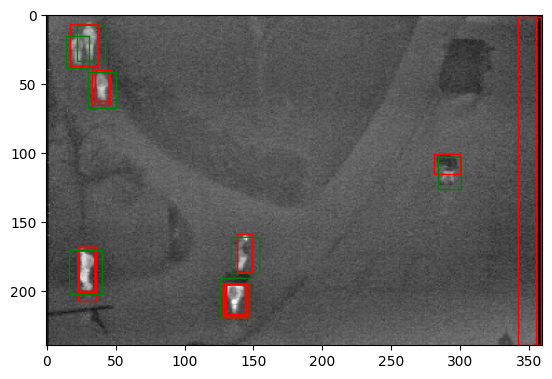

Image 30 : img_00031.bmp
img_00031.bmp
No. of boxes in image 30 : 7
No. of boxes in image 30 : 7
No. of boxes in image 30 : 7
No. of boxes in image 30 : 7
No. of boxes in image 30 : 7
No. of boxes in image 30 : 7
No. of boxes in image 30 : 7


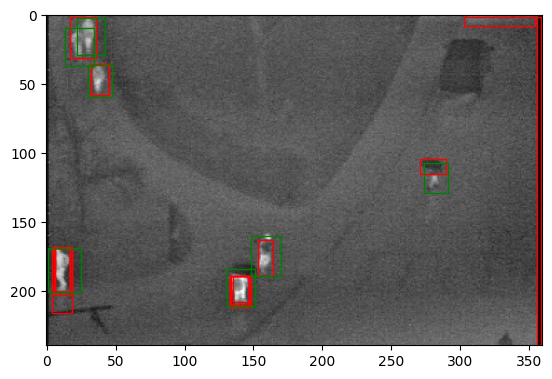

In [4]:
### Visualize images
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2

# Path to the folder
path="./datasets/OTCBVS_Pedestrian"

# Get images and bounding boxes
images, boxes = read_images(path)

# Get MSER regions
regions = getMSERregionsAll(images)

# Loop over the 10 folders
for i in range(1,2):
    # Path to the folder
    if i < 10:
        path_folder = path + "/0000" + str(i)
        key = "0000" + str(i)
    else:
        path_folder = path + "/000" + str(i)
        key = "000" + str(i)
    # Path to the .bmp files
    path_bmp = path_folder
    # List of the .bmp files
    list_bmp = os.listdir(path_bmp)

    list_bmp.sort()
    list_bmp.pop(0)
    list_bmp.pop(0)
    # Loop over the .bmp files
    # print(len(boxes[key]))
    for j in range(0,len(boxes[key])):
        print("Image " + str(j) + " : " + list_bmp[j])
        if list_bmp[j].endswith(".bmp"):
            # Path to the .bmp file
            print(list_bmp[j])
            path_bmp_file = path_bmp + "/" + list_bmp[j]
            # Read the .bmp file
            img = cv2.imread(path_bmp_file)
            # Convert image to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Create figure and axes
            fig, ax = plt.subplots(1)
            # Display the image
            ax.imshow(img, cmap='gray')
            # Loop over the MSER regions

            for region in regions[key][j]:
                # Create a Rectangle patch
                rect1 = patches.Rectangle((region[0],region[1]),region[2]-region[0],region[3]-region[1],linewidth=1,edgecolor='r',facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect1)
            # Loop over the groundtruth bounding boxes
            for box in boxes[key][j]:
                # Create a Rectangle patch
                print("No. of boxes in image " + str(j) + " : " + str(len(boxes[key][j])))
                rect2 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='g',facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect2)
            # Display the figure
            
            plt.show()
            # Close the figure
            plt.close(fig)

